In [93]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Загружаем датасет, удаляем переменные, которые требуется удалить согласно заданию

In [9]:
df = pd.read_csv("AB_NYC_2019.csv")
df = df.drop(columns=['id', 'name', 'host_id', 'host_name', 'last_review'])

# EDA

In [10]:
df.shape

(48895, 11)

In [11]:
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


Проведем небольшой разведовательный анализ данных

In [16]:
df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


Что необычного видим:
есть записи с ценой 0 - возможно выбросы
почти по всем переменным максимальное значение существенно превыешает медиану. Возможно выбросы или длинный правый хвост.

In [15]:
df.isnull().sum()/df.count()*100

neighbourhood_group                0.000000
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
reviews_per_month                 25.878537
calculated_host_listings_count     0.000000
availability_365                   0.000000
dtype: float64

Миссинги есть только в пременной reviews per month, их много, надо заменять.
Будем заменять на 0, так как это близко по смыслу

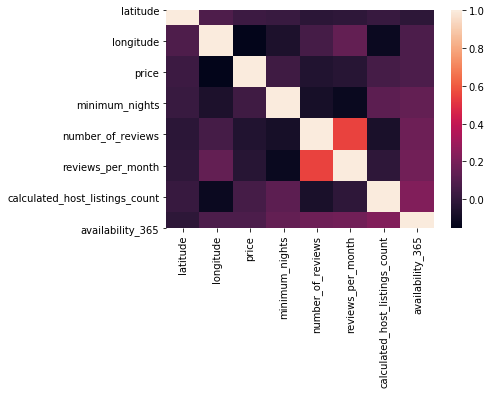

In [18]:
sns.heatmap(df.corr())

На матрице корреляций не вижу ничего необчного. Хорошо корррелированы количество отзывов и число отзывов в месяц.
надо будет попробовать исключить одну их этих переменных из модели и посмотреть, улучшится ли качество

C:\Users\Asus\Miniconda3\envs\otus_ml\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Asus\Miniconda3\envs\otus_ml\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


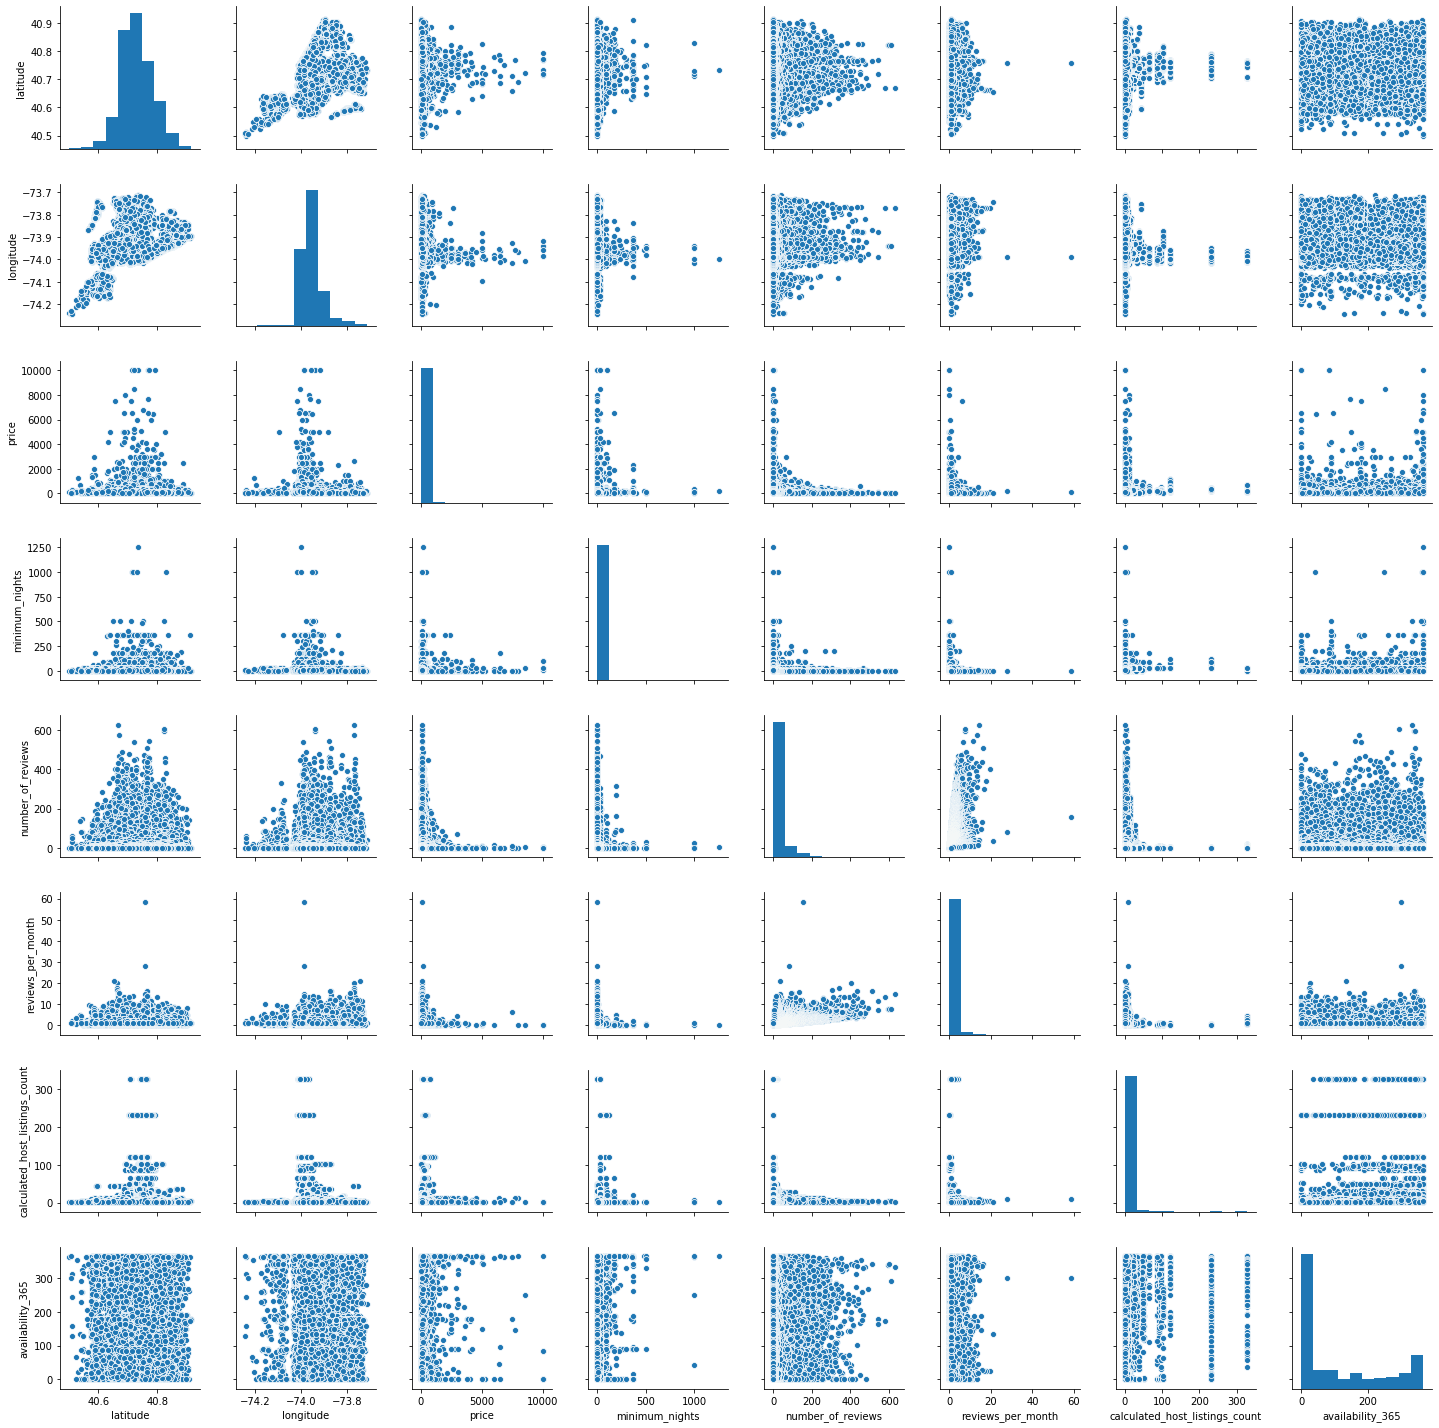

In [19]:
sns.pairplot(df)

Что заметил:\
Некоторое количество далекостоящих точек. На вид как аутлаеры\
avaylability_365 vs calculated_host_listings_count показывает полосочки. Можно эти полосочки выделить в категориальные переменные

слишком двухмерно. попробуем добавить цены на визуализацию

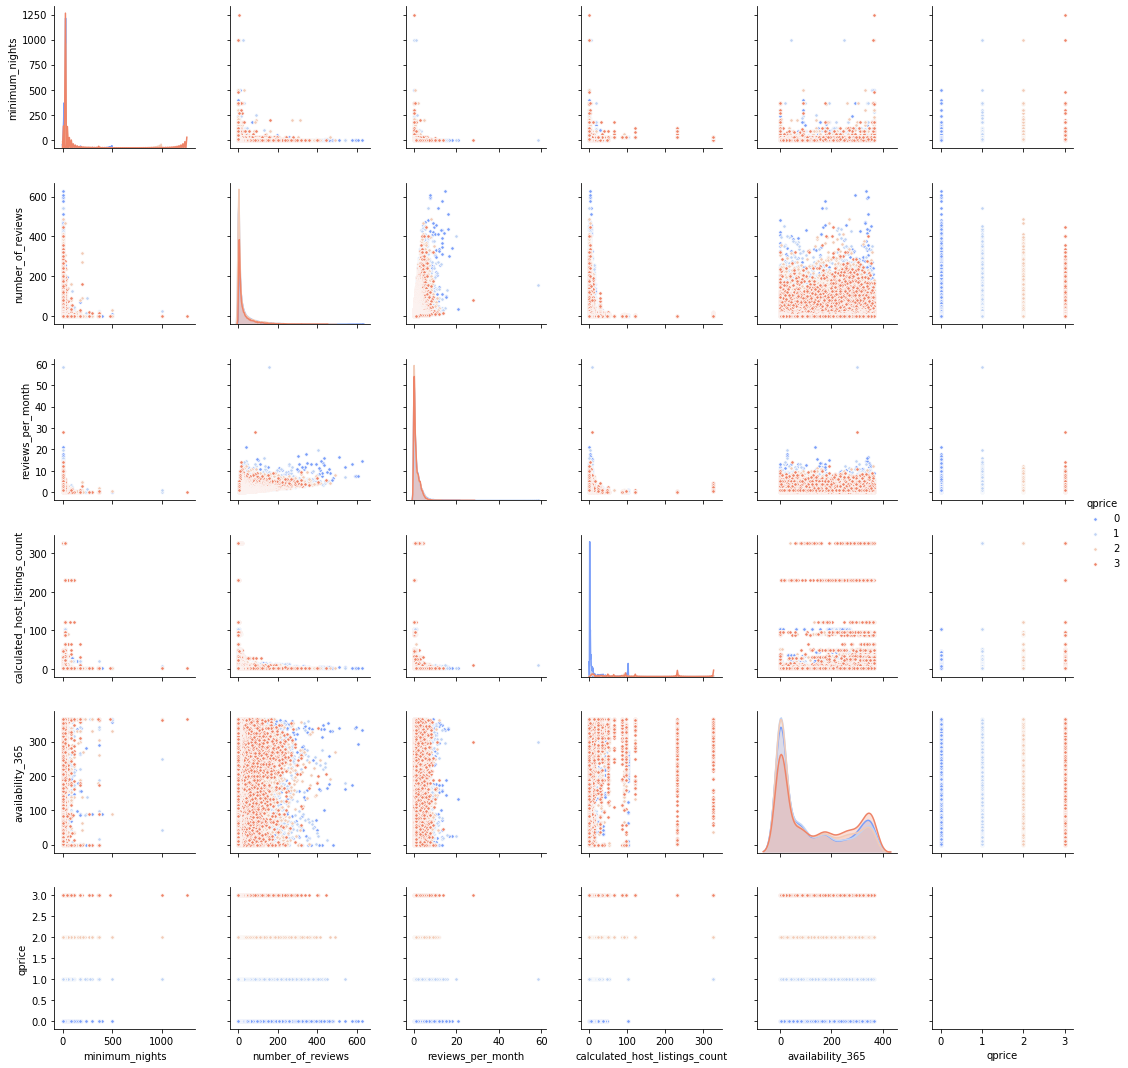

In [48]:
_ = pd.concat([df, pd.qcut(df.price,4,labels=list(range(4))).rename('qprice')], axis=1)
sns.pairplot(_.drop(columns=['price','latitude','longitude']),hue='qprice', palette='coolwarm',plot_kws={"s": 12})

Интересные группы, позволяющие линейно разделить ценовые сегменты\
number_of_reviews vs review_per_month\
number_of_reviews vs availability_365\
calculated_host_listing_count сам по себе хорош, позволяет выделить дешевые номера


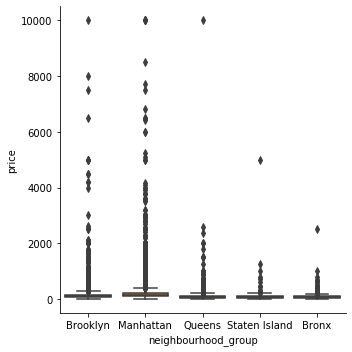

In [57]:
sns.catplot(x='neighbourhood_group', y='price', kind='box',data=df);

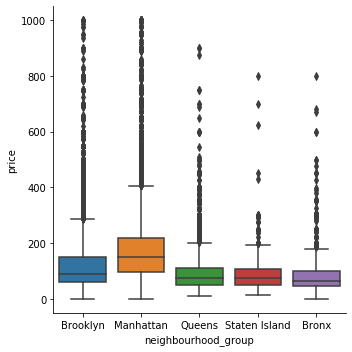

In [59]:
# изза длинных хвостов не видно центров распределения. отрежем самые высокие цены
sns.catplot(x='neighbourhood_group', y='price', kind='box',data=df[df.price<1000]);

Видим, что бруклин и манхэтэн явно дороже прочих

районов слишком много для визуальной оценки, попробуем оценить численно

In [64]:
df.groupby(by = 'neighbourhood').price.describe().sort_values(by='50%')

,count,mean,std,min,25%,50%,75%,max
neighbourhood,,,,,,,,
Concord,26.0,58.192308,45.507818,29.0,32.00,34.5,75.00,200.0
Castle Hill,9.0,63.000000,33.462666,38.0,39.00,39.0,86.00,128.0
New Dorp Beach,5.0,57.400000,30.607189,36.0,40.00,40.0,62.00,109.0
Corona,64.0,59.171875,49.300682,23.0,35.75,40.0,69.25,359.0
Hunts Point,18.0,50.500000,27.181849,35.0,37.00,40.0,55.50,150.0
...,...,...,...,...,...,...,...,...
NoHo,78.0,295.717949,218.199593,75.0,179.25,250.0,350.00,1795.0
Neponsit,3.0,274.666667,75.002222,200.0,237.00,274.0,312.00,350.0
Tribeca,177.0,490.638418,856.341720,60.0,200.00,295.0,485.00,8500.0


Медианы цен сильно отличаются по районам, однако далеко не в каждом районе есть достаточное число записей

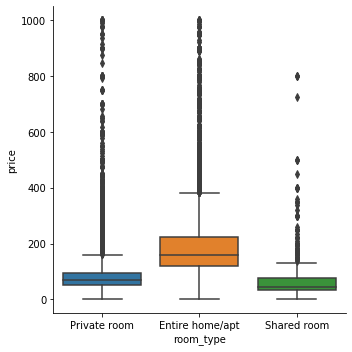

In [77]:
sns.catplot(x='room_type', y='price', kind='box',data=df[df.price<1000]);

Согласно заданию необходимо создать переменную, хранящую расстояние до центра города. Найдем это расстояние, используя нагугленные координаты (40.4342 ,  -73.5939)

In [415]:
df["center_distance"] = ( 
    (df.latitude - 40.4342)*(df.latitude - 40.4342) +
    (df.longitude + 73.5939)*(df.longitude + 73.5939) 
).map(pd.np.sqrt)

In [416]:
df

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,center_distance
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365,0.434433
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355,0.504012
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,0.00,1,365,0.511463
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194,0.443649
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0,0.505257
...,...,...,...,...,...,...,...,...,...,...,...,...
48890,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,0.00,2,9,0.431820
48891,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,0.00,2,36,0.432129
48892,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,0.00,1,27,0.520269
48893,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,0.00,6,2,0.512165


In [417]:
# Подготовка данных

In [418]:
df.fillna(0, inplace=True)

In [419]:
df = df[df.price>0]

In [420]:
df_encoded = pd.concat([
df.drop(['room_type','neighbourhood_group','neighbourhood','latitude','longitude'], axis=1),
pd.get_dummies(df.room_type, prefix='room_type',drop_first =True),
pd.get_dummies(df.neighbourhood_group, prefix='neighbourhood_group',drop_first =True),
# pd.get_dummies(df.neighbourhood, prefix='neighbourhood',drop_first =True)
    
    ],axis=1)

In [421]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [422]:
rs  =RobustScaler(quantile_range=(5,95))

In [423]:
df_train, df_test = train_test_split(df_encoded, test_size = 0.3)

In [424]:
interval_columns = ['minimum_nights','number_of_reviews','reviews_per_month',
                    'calculated_host_listings_count', 'availability_365', 'center_distance' ]

In [425]:
rs.fit(df_train[interval_columns])

RobustScaler(copy=True, quantile_range=(5, 95), with_centering=True,
             with_scaling=True)

In [426]:
df_train_scale = rs.transform(df_train[interval_columns]).copy()
df_test_scale = rs.transform(df_test[interval_columns]).copy()

In [427]:
df_train.loc[:,[*interval_columns]] = df_train_scale.copy()
df_test.loc[:,[*interval_columns]] = df_test_scale.copy()

C:\Users\Asus\Miniconda3\envs\otus_ml\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [428]:
y_train = df_train.price
y_test = df_test.price

X_train = df_train.drop(columns='price')
X_test = df_test.drop(columns='price')

In [429]:
from sklearn import metrics
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = pd.np.array(y_true), pd.np.array(y_pred)
    return pd.np.mean(pd.np.abs((y_true - y_pred) / y_true)) * 100
def print_metrics(y_test,y_pred):
    print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
    print('RMSE:', pd.np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('R2:',  metrics.r2_score(y_test, y_pred))
    print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))
    pass

In [430]:
from sklearn import linear_model

построим простую линейную регрессию

In [431]:
%%time
reg1 = linear_model.LinearRegression()
reg1.fit(X_train, y_train)
print_metrics(y_test, reg1.predict(X_test))

MAE: 74.72717405401362
RMSE: 243.66862360622537
R2: 0.08103674765837954
MAPE: 56.07091548306893
Wall time: 33.6 ms


Получили очень плохие результаты. Скорее всего всему виной большое количество мусорных переменных\
Добавим регуляризацию

In [432]:
%%time
reg2 = linear_model.RidgeCV(cv=5,alphas=pd.np.linspace(0.01,100,50))
reg2.fit(X_train, y_train)
print_metrics(y_test, reg2.predict(X_test))

MAE: 74.68656076483657
RMSE: 243.66968129587985
R2: 0.08102876977415308
MAPE: 56.054616640457056
Wall time: 3.38 s


Все еще плохие результаты

In [433]:
%%time
reg3 = linear_model.LassoCV(cv=5, alphas=pd.np.linspace(0.01,100,50))
reg3.fit(X_train, y_train)
print_metrics(y_test, reg3.predict(X_test))

MAE: 74.7092446101822
RMSE: 243.66802142967842
R2: 0.08104128970754532
MAPE: 56.048999153284655
Wall time: 321 ms


In [434]:
reg3.alpha_

0.01

In [435]:
%%time
reg4 = linear_model.ElasticNetCV(cv=5)
reg4.fit(X_train, y_train)
print_metrics(y_test, reg4.predict(X_test))

MAE: 74.29146088529066
RMSE: 244.30651811905253
R2: 0.07621898401389593
MAPE: 58.74894696225561
Wall time: 454 ms


Пока очень плохие результаты. Попробуем применить логарифмирование к целевой переменной

In [436]:
y_train2 = pd.np.log(y_train)

In [437]:
%%time
reg5 = linear_model.LinearRegression()
reg5.fit(X_train, y_train2)
print_metrics(y_test, pd.np.exp(reg5.predict(X_test)))

MAE: 64.36650292497092
RMSE: 245.33278492751128
R2: 0.06844156532999268
MAPE: 38.32948863975836
Wall time: 24.5 ms


In [438]:
# стало гораздо лучше

In [439]:
%%time
reg6 = linear_model.RidgeCV(cv=5)
reg6.fit(X_train, y_train2)
print_metrics(y_test, pd.np.exp(reg6.predict(X_test)))

MAE: 64.36602422390158
RMSE: 245.3349843126851
R2: 0.06842486258890368
MAPE: 38.32968963024732
Wall time: 234 ms


In [440]:
%%time
reg7 = linear_model.LassoCV(cv=5)
reg7.fit(X_train, y_train2)
print_metrics(y_test, pd.np.exp(reg7.predict(X_test)))

MAE: 64.36194873013723
RMSE: 245.3597861147517
R2: 0.06823650045943397
MAPE: 38.326268958551694
Wall time: 432 ms


C:\Users\Asus\Miniconda3\envs\otus_ml\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  


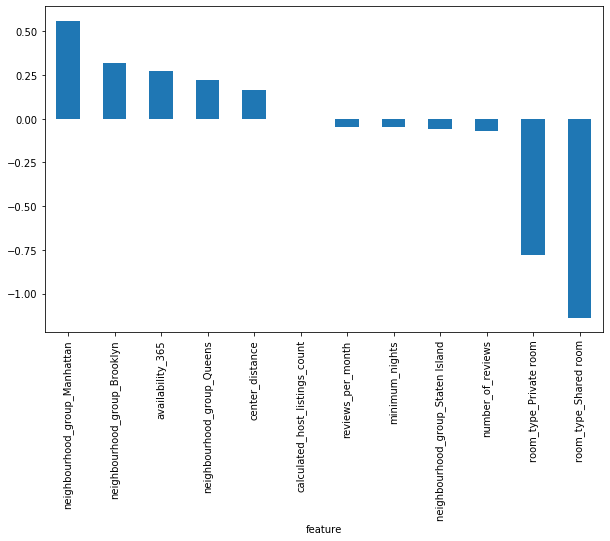

In [441]:
featureImportance = pd.DataFrame({"feature": df_train.drop('price',axis=1).columns, 
                                  "importance": reg7.coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar', figsize=(10, 6));

In [445]:
featureImportance

,importance
feature,
neighbourhood_group_Manhattan,0.558380
neighbourhood_group_Brooklyn,0.318579
availability_365,0.271597
neighbourhood_group_Queens,0.218875
center_distance,0.164416
calculated_host_listings_count,0.001013
reviews_per_month,-0.045941
minimum_nights,-0.046448
neighbourhood_group_Staten Island,-0.060315
